In [1]:
from IPython import get_ipython
get_ipython().magic('reset -sf')

In [20]:
import pandas as pd
import numpy as np
# np.set_printoptions(suppress=True) # чтоб без e
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import time
from pylab import *

%matplotlib inline

In [3]:
start_time = time.time()
df = pd.read_csv('traffic_moscow.csv', header=None)
df.columns = ["i", "j", "amt", "t", "s"]
print("--- %s seconds ---" % (time.time() - start_time))
df.head()

--- 0.01526498794555664 seconds ---


,i,j,amt,t,s
0,1,1,40,26,2.2
1,1,2,4,49,8.1
2,1,3,3,35,6.8
3,1,4,2,75,9.3
4,1,5,2,30,8.0


##### Надо учесть коэффициент 1.62
для этого добавить столбец принадлежности к Москве-области и умножить amt москвичей на 1.62

In [4]:
def make_index(i, j):
    residents = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    if int(i) in residents:
        return 1 # живут в Москве
    else:
        return 0 # живут в области

In [5]:
df['r'] = df.apply(lambda row: make_index(row['i'], 
                                              row['j']), axis=1) # добавили столбец

In [6]:
def amt_for_residents(df): # умножили значения москвичей на 1.62
    for i in range(df.shape[0]):
        df.loc[i, 'amt'] *= 1.62 if df.loc[i, 'r'] == 1 else 1
    return df

df = amt_for_residents(df)

#### Cначала попробовать в качестве издержек время

Считаем $L_i$, где $L_i$ -- это объем отправления из i. Причём $sum$ ($L_i$) = $sum$ ($W_j$), где $W_j$ -- это объём прибытия в район j.


In [7]:
L_i = df.groupby('i')['amt'].sum().reset_index()
W_j = df.groupby('j')['amt'].sum().reset_index()

total_i = L_i['amt'].sum()
total_j = W_j['amt'].sum()

print(total_i, total_j)

2571.36 2571.3599999999997


In [8]:
print(L_i.head())

   i     amt
0  1  108.54
1  2  197.64
2  3  204.12
3  4  158.76
4  5  183.06


In [9]:
print(W_j.head())

   j     amt
0  1  512.82
1  2  208.58
2  3  163.98
3  4  153.64
4  5  153.50


###### Теперь надо решать систему и искать $d_{ij}$
Метод последовательных итераций.
##### Вопрос: куда девать $alpha$? 
Пока примем $alpha$ за единицу. Потом надо что-то решать.
##### UPDATE: просто A_i и B_i надо всё время пересчитывать в gravity func, а не считать заранее!
##### Вопрос: что такое $T_{ij}$?
$T_{ij}$ -- это издержки. Издержки -- это время t.
#### Проблема: i с j не всегда пересекаются. Не получается вернуть издержку. Возвращаю ноль
Пока что возвращаю в таких случаях 0.

In [10]:
def costs_func(i, j, alpha):
    rows = df.loc[df['i'] == i]
    columns = rows.loc[df['j'] == j]
    t = columns['t'] # потому что издержки -- это время
    try:
        t = int(t)
        return np.exp(np.dot(-alpha, t))
    except TypeError: # если не пересекается район i с районом j
        return 0

def iteration_method(L_i, W_j, alpha):
    A_i = 1
    B_j = 1
    list_A_i = []
    list_B_j = []
    n = L_i.shape[0] # количество районов
    for i in range(1, n+1): # нумерация районов начинается с 1
        for j in range(1, n+1):
            value_i = L_i.loc[L_i['i'] == i]['amt']
            value_j = W_j.loc[W_j['j'] == j]['amt']
            value_i = int(value_i)
            value_j = int(value_j)
            denominator_i = B_j*value_i*costs_func(i, j, alpha)
            denominator_j = A_i*value_j*costs_func(i, j, alpha)
            if denominator_i!=0:
                A_i += denominator_i 
                list_A_i.append(1 / A_i) # вызывает вопросы обращать тут или строкой выше
            else:
                list_A_i.append(0)
            if denominator_j!=0:
                B_j += denominator_j
                list_B_j.append(1 / B_j)
            else:
                list_B_j.append(0)

    return list_A_i, list_B_j

###### Пр мнмзрвать фнкцинл, Птчк

In [11]:
def gravity_func(alpha):
    n = L_i.shape[0] # количество районов
    d_i_j = np.zeros((n+1, n+1))
    list_A_i, list_B_j = iteration_method(L_i, W_j, alpha) # добавлено сюда, чтобы считать с нужным alpha
    for i in range(1, n+1): # нумерация районов начинается с 1
        for j in range(1, n+1):

            value_i = L_i.loc[L_i['i'] == i]['amt']
            value_j = W_j.loc[W_j['j'] == j]['amt']
            value_i = int(value_i)
            value_j = int(value_j)
            cost = costs_func(i, j, alpha)
            if cost!=0:
                d_i_j[i][j] = (list_A_i[i]*list_B_j[j]*value_i*value_j)*cost #умножить потому что -alpha в функции
            else:
                d_i_j[i][j] = 0
    return d_i_j

def minimaze_func(real_d_i_j, alpha):
    d_i_j = gravity_func(alpha) # добавлено сюда, чтобы считать с нужным alpha
    n = L_i.shape[0] # количество районов
    s = 0
    for i in range(n):
        for j in range(n):
            s += (real_d_i_j[i][j] - d_i_j[i][j])**2
    return s

def get_real_d_i_j(df): # чтобы натыкать нулей в местах, где нет пересечений
    n = L_i.shape[0]
    real_d = np.zeros((n+1, n+1))
    for i in range(1, n+1):
        for j in range(1, n+1):
            value = df.loc[df['i'] == i]
            value = value.loc[value['j'] == j]['amt']
            try:
                value = int(value)
            except TypeError: # если не пересекается район i с районом j
                value = 0
            real_d[i][j] = value
    return real_d

##### графики ниже БЕЗ поправок Мерузы и исправленной минимизирующей функции

In [14]:
real_d_i_j = get_real_d_i_j(df)

In [15]:
alpha_list = []
minimize_list =[]
for alpha in np.arange(0, 0.5, 0.01):
    value = minimaze_func(real_d_i_j, alpha)
    print('alpha: ', alpha, 'min: ', value)
    alpha_list.append(alpha)
    minimize_list.append(value)

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in double_scalars
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in double_scalars
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


alpha:  0.0 min:  117039.99434314598
alpha:  0.01 min:  117039.98077377593
alpha:  0.02 min:  117039.93531075206
alpha:  0.03 min:  117039.78566795413
alpha:  0.04 min:  117039.30590902446
alpha:  0.05 min:  117037.82454501034
alpha:  0.06 min:  117033.47909015707
alpha:  0.07 min:  117021.55541929668
alpha:  0.08 min:  116991.42632242411
alpha:  0.09 min:  116922.06240810403
alpha:  0.1 min:  116777.2497791617
alpha:  0.11 min:  116504.99827656975
alpha:  0.12 min:  116049.8137719443
alpha:  0.13 min:  115378.32212085077
alpha:  0.14 min:  114493.6879479648
alpha:  0.15 min:  113417.68731550305
alpha:  0.16 min:  112168.29231512832
alpha:  0.17 min:  110771.30035299927
alpha:  0.18 min:  109291.88570136619
alpha:  0.19 min:  107844.429498997
alpha:  0.2 min:  106571.44326018143
alpha:  0.21 min:  105611.24367881556
alpha:  0.22 min:  105067.58958337724
alpha:  0.23 min:  104987.059211989
alpha:  0.24 min:  105352.11105358912
alpha:  0.25 min:  106092.05085768277
alpha:  0.26 min:  107

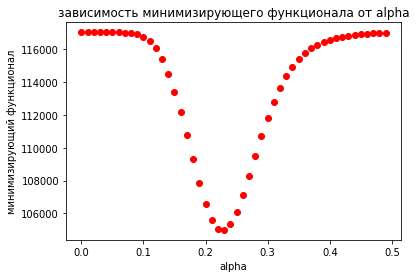

In [20]:
plt.plot(alpha_list, minimize_list, 'ro')
plt.title('зависимость минимизирующего функционала от alpha')
plt.xlabel('alpha')
plt.ylabel('минимизирующий функционал') # см. функцию  minimaze_func
# xlim(0, 0.2)
# ylim(5000, 10000)
plt.show()

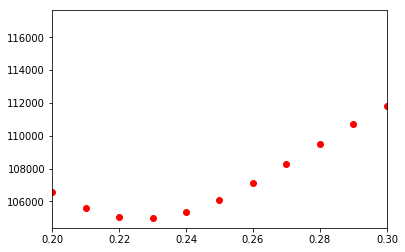

In [18]:
# более приближенный график
plt.plot(alpha_list, minimize_list, 'ro')
xlim(0.2, 0.3)
plt.show()

##### Поправки Мерузы

1. Отнормировать минимизируемую функцию (minimize_func) по alpha = 0
2. Издержки сделать бесконечностью

##### Далее исправлен ТОЛЬКО первый пункт

In [44]:
def minimaze_func(real_d_i_j, alpha):
    d_i_j = gravity_func(alpha) # добавлено сюда, чтобы считать с нужным alpha
    d_i_j_alpha_0 = gravity_func(alpha=0)
    n = L_i.shape[0] # количество районов
    s = 0
    for i in range(n):
        for j in range(n):
            numerator = (real_d_i_j[i][j] - d_i_j[i][j])**2 # числитель
            denominator = (real_d_i_j[i][j] - d_i_j_alpha_0[i][j])**2 # знаменатель
            if denominator != 0:
                s += numerator / denominator
            else:
                s += 0
    return s

In [43]:
real_d_i_j = get_real_d_i_j(df)

alpha_list = []
minimize_list =[]
for alpha in np.arange(0, 0.5, 0.01):
    value = minimaze_func(real_d_i_j, alpha)
    alpha_list.append(alpha)
    minimize_list.append(value)
    print('alpha: ', alpha, 'min: ', value)

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in double_scalars
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in double_scalars
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


alpha:  0.0 min:  206.0
alpha:  0.01 min:  205.99999654840633
alpha:  0.02 min:  205.99998492979805
alpha:  0.03 min:  205.99994641480657
alpha:  0.04 min:  205.9998214430437
alpha:  0.05 min:  205.9994274354781
alpha:  0.06 min:  205.99823090383643
alpha:  0.07 min:  205.9947648117176
alpha:  0.08 min:  205.98525706833684
alpha:  0.09 min:  205.96048931933584
alpha:  0.1 min:  205.89896320455495
alpha:  0.11 min:  205.75583508489382
alpha:  0.12 min:  205.45321114908745
alpha:  0.13 min:  204.87670770963476
alpha:  0.14 min:  203.89812681785008
alpha:  0.15 min:  202.6004403876101
alpha:  0.16 min:  201.98003385806064
alpha:  0.17 min:  204.52314793646622
alpha:  0.18 min:  212.8778009474332
alpha:  0.19 min:  226.9205841547136
alpha:  0.2 min:  242.74064151971064
alpha:  0.21 min:  255.02599003459227
alpha:  0.22 min:  260.2445949045739
alpha:  0.23 min:  257.9608672008692
alpha:  0.24 min:  250.13564155414616
alpha:  0.25 min:  239.64595801979087
alpha:  0.26 min:  229.0571350111544

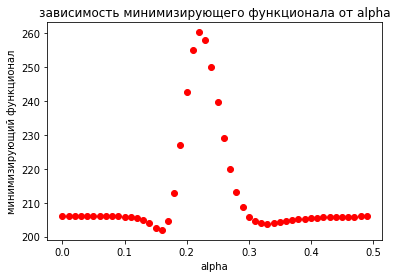

In [45]:
plt.plot(alpha_list, minimize_list, 'ro')
plt.title('зависимость минимизирующего функционала от alpha')
plt.xlabel('alpha')
plt.ylabel('минимизирующий функционал') # см. функцию  minimaze_func
# xlim(0, 0.2)
# ylim(5000, 10000)
plt.show()

##### Первый и второй пункт сразу, нули исправлены на np.inf()

In [131]:
def costs_func(i, j, alpha):
    rows = df.loc[df['i'] == i]
    columns = rows.loc[df['j'] == j]
    t = columns['t'] # потому что издержки -- это время
    try:
        t = int(t)
        return np.exp(np.dot(-alpha, t))
    except TypeError: # если не пересекается район i с районом j
        return np.inf # возвращаем бесконечность

def iteration_method(L_i, W_j, alpha):
    A_i = 1
    B_j = 1
    list_A_i = []
    list_B_j = []
    n = L_i.shape[0] # количество районов
    for i in range(1, n+1): # нумерация районов начинается с 1
        for j in range(1, n+1):
            value_i = L_i.loc[L_i['i'] == i]['amt']
            value_j = W_j.loc[W_j['j'] == j]['amt']
            value_i = int(value_i)
            value_j = int(value_j)
            denominator_i = B_j*value_i*costs_func(i, j, alpha)
            denominator_j = A_i*value_j*costs_func(i, j, alpha)
            
            if np.isinf(denominator_i): # если не пересекаются районы, т.е. бесконечность
                list_A_i.append(np.inf) # добавляем бесконечность
            else:
                A_i += denominator_i 
                list_A_i.append(1 / A_i)
            if np.isinf(denominator_j):
                list_B_j.append(np.inf)
            else:
                B_j += denominator_j
                list_B_j.append(1 / B_j)
    return list_A_i, list_B_j

def gravity_func(alpha):
    n = L_i.shape[0] # количество районов
    d_i_j = np.zeros((n+1, n+1))
    list_A_i, list_B_j = iteration_method(L_i, W_j, alpha) # добавлено сюда, чтобы считать с нужным alpha
    for i in range(1, n+1): # нумерация районов начинается с 1
        for j in range(1, n+1):

            value_i = L_i.loc[L_i['i'] == i]['amt']
            value_j = W_j.loc[W_j['j'] == j]['amt']
            value_i = int(value_i)
            value_j = int(value_j)
            cost = costs_func(i, j, alpha)
            if np.isinf(cost):
                d_i_j[i][j] = np.inf
            else:
                d_i_j[i][j] = (list_A_i[i]*list_B_j[j]*value_i*value_j)*cost #умножить потому что -alpha в функции
    return d_i_j

def minimaze_func(real_d_i_j, alpha):
    d_i_j = gravity_func(alpha) # добавлено сюда, чтобы считать с нужным alpha
    d_i_j_alpha_0 = gravity_func(alpha=0)
    n = L_i.shape[0] # количество районов
    s = 0
    list_s = []
    for i in range(n):
        for j in range(n):
            numerator = (real_d_i_j[i][j] - d_i_j[i][j])**2 # числитель
            denominator = (real_d_i_j[i][j] - d_i_j_alpha_0[i][j])**2 # знаменатель
            if np.isinf(denominator):
                s += np.inf
                list_s.append(np.inf)
            else:
                if denominator != 0:
                    s += numerator / denominator
                    list_s.append(numerator / denominator)
                else:
                    s += 0
                    list_s.append(0)
    return s, list_s

def get_real_d_i_j(df): # чтобы натыкать нулей в местах, где нет пересечений
    n = L_i.shape[0]
    real_d = np.zeros((n+1, n+1))
    for i in range(1, n+1):
        for j in range(1, n+1):
            value = df.loc[df['i'] == i]
            value = value.loc[value['j'] == j]['amt']
            try:
                value = int(value)
            except TypeError: # если не пересекается район i с районом j
                value = np.inf
            real_d[i][j] = value
    return real_d

In [132]:
real_d_i_j = get_real_d_i_j(df)
list_s = []
alpha_list = []
minimize_list =[]

for alpha in np.arange(0, 0.3, 0.1):
    value, list_s = minimaze_func(real_d_i_j, alpha)
    alpha_list.append(alpha)
    minimize_list.append(value)
    print('alpha: ', alpha, 'min: ', value)

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in double_scalars
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in double_scalars
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in double_scalars
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in double_scalars


alpha:  0.0 min:  nan
alpha:  0.1 min:  nan
alpha:  0.2 min:  nan


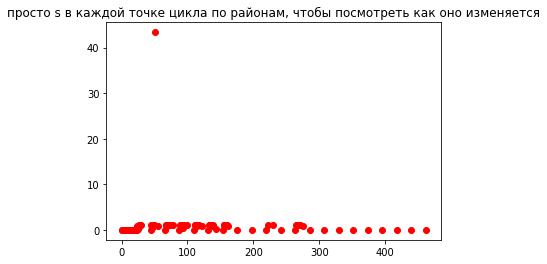

In [136]:
plt.plot(list_s, 'ro')
plt.title('просто s в каждой точке цикла по районам, чтобы посмотреть как оно изменяется')
# xlim(0, 0.2)
# ylim(0, 1)
plt.show()

##### Первый и второй пункт сразу, нули исправлены не на np.inf, а на самую большую издержку В КВАДРАТЕ, что есть у нас в таблице

In [12]:
max_t = df.loc[df['t'].idxmax()]
max_t = max_t['t']
max_t = max_t**2
print(max_t)

57600.0


In [13]:
def costs_func(i, j, alpha):
    rows = df.loc[df['i'] == i]
    columns = rows.loc[df['j'] == j]
    t = columns['t'] # потому что издержки -- это время
    try:
        t = int(t)
        return np.exp(np.dot(-alpha, t))
    except TypeError: # если не пересекается район i с районом j
        return max_t

def iteration_method(L_i, W_j, alpha):
    A_i = 1
    B_j = 1
    list_A_i = []
    list_B_j = []
    n = L_i.shape[0] # количество районов
    for i in range(1, n+1): # нумерация районов начинается с 1
        for j in range(1, n+1):
            value_i = L_i.loc[L_i['i'] == i]['amt']
            value_j = W_j.loc[W_j['j'] == j]['amt']
            value_i = int(value_i)
            value_j = int(value_j)
            denominator_i = B_j*value_i*costs_func(i, j, alpha)
            denominator_j = A_i*value_j*costs_func(i, j, alpha)
            if denominator_i!=0:
                A_i += denominator_i 
                list_A_i.append(1 / A_i) # вызывает вопросы обращать тут или строкой выше
            else:
                list_A_i.append(0)
            if denominator_j!=0:
                B_j += denominator_j
                list_B_j.append(1 / B_j)
            else:
                list_B_j.append(0)

    return list_A_i, list_B_j

def gravity_func(alpha):
    n = L_i.shape[0] # количество районов
    d_i_j = np.zeros((n+1, n+1))
    list_A_i, list_B_j = iteration_method(L_i, W_j, alpha) # добавлено сюда, чтобы считать с нужным alpha
    for i in range(1, n+1): # нумерация районов начинается с 1
        for j in range(1, n+1):

            value_i = L_i.loc[L_i['i'] == i]['amt']
            value_j = W_j.loc[W_j['j'] == j]['amt']
            value_i = int(value_i)
            value_j = int(value_j)
            cost = costs_func(i, j, alpha)
            if cost!=0:
                d_i_j[i][j] = (list_A_i[i]*list_B_j[j]*value_i*value_j)*cost #умножить потому что -alpha в функции
            else:
                d_i_j[i][j] = 0
    return d_i_j

def minimaze_func(real_d_i_j, alpha):
    d_i_j = gravity_func(alpha) # добавлено сюда, чтобы считать с нужным alpha
    d_i_j_alpha_0 = gravity_func(alpha=0)
    n = L_i.shape[0] # количество районов
    s = 0
    for i in range(n):
        for j in range(n):
            numerator = (real_d_i_j[i][j] - d_i_j[i][j])**2 # числитель
            denominator = (real_d_i_j[i][j] - d_i_j_alpha_0[i][j])**2 # знаменатель
            if denominator != 0:
                s += numerator / denominator
#                 print(s, numerator, denominator)
            else:
                s += 0
    return s

def get_real_d_i_j(df): # чтобы натыкать нулей в местах, где нет пересечений
    n = L_i.shape[0]
    real_d = np.zeros((n+1, n+1))
    for i in range(1, n+1):
        for j in range(1, n+1):
            value = df.loc[df['i'] == i]
            value = value.loc[value['j'] == j]['amt']
            try:
                value = int(value)
            except TypeError: # если не пересекается район i с районом j
                value = 0
            real_d[i][j] = value
    return real_d

In [125]:
real_d_i_j = get_real_d_i_j(df)
list_s = []
alpha_list = []
minimize_list = []

for alpha in np.arange(0, 2.1, 0.1):
    value = minimaze_func(real_d_i_j, alpha)
    alpha_list.append(alpha)
    minimize_list.append(value)
    print('alpha: ', alpha, 'min: ', value)

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in double_scalars
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in double_scalars


alpha:  0.0 min:  427.0
alpha:  0.1 min:  1.690594294297507e+67
alpha:  0.2 min:  1.3760978424480482e+84
alpha:  0.30000000000000004 min:  1.486257161203373e+87
alpha:  0.4 min:  3.8379807148007863e+87
alpha:  0.5 min:  4.121130360725836e+87
alpha:  0.6000000000000001 min:  4.141211336945963e+87
alpha:  0.7000000000000001 min:  4.142610232989188e+87
alpha:  0.8 min:  4.142709355067351e+87
alpha:  0.9 min:  4.14271647986346e+87
alpha:  1.0 min:  4.142716997274834e+87
alpha:  1.1 min:  4.142717035120176e+87
alpha:  1.2000000000000002 min:  4.1427170379020214e+87
alpha:  1.3 min:  4.14271703810719e+87
alpha:  1.4000000000000001 min:  4.1427170381223535e+87
alpha:  1.5 min:  4.142717038123482e+87
alpha:  1.6 min:  4.142717038123561e+87
alpha:  1.7000000000000002 min:  4.142717038123565e+87
alpha:  1.8 min:  4.142717038123565e+87
alpha:  1.9000000000000001 min:  4.142717038123565e+87
alpha:  2.0 min:  4.142717038123565e+87


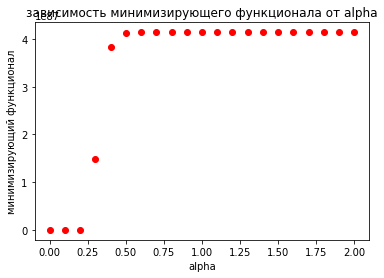

In [128]:
plt.plot(alpha_list, minimize_list, 'ro')
plt.title('зависимость минимизирующего функционала от alpha')
plt.xlabel('alpha')
plt.ylabel('минимизирующий функционал') # см. функцию  minimaze_func
# xlim(0, 0.25)
# ylim(5000, 10000)
plt.show()

In [14]:
real_d_i_j = get_real_d_i_j(df)
list_s = []
alpha_list = []
minimize_list = []

for alpha in np.arange(0, 1.0, 0.01):
    value = minimaze_func(real_d_i_j, alpha)
    alpha_list.append(alpha)
    minimize_list.append(value)
    print('alpha: ', alpha, 'min: ', value)

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in double_scalars
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in double_scalars


alpha:  0.0 min:  427.0
alpha:  0.01 min:  3019291376.023451
alpha:  0.02 min:  8.383387009019386e+16
alpha:  0.03 min:  2.431910324110451e+24
alpha:  0.04 min:  6.140990828256307e+31
alpha:  0.05 min:  1.0389119980620333e+39
alpha:  0.06 min:  7.628650401072488e+45
alpha:  0.07 min:  1.5696411567514395e+52
alpha:  0.08 min:  7.537098341164558e+57
alpha:  0.09 min:  8.024966815625137e+62
alpha:  0.1 min:  1.690594294297507e+67
alpha:  0.11 min:  6.617364702434282e+70
alpha:  0.12 min:  5.304840499025599e+73
alpha:  0.13 min:  1.0845783213455936e+76
alpha:  0.14 min:  7.41535639542682e+77
alpha:  0.15 min:  2.24620465222087e+79
alpha:  0.16 min:  3.875016218156094e+80
alpha:  0.17 min:  4.5479973806530315e+81
alpha:  0.18 min:  3.982391355269703e+82
alpha:  0.19 min:  2.673753898157704e+83
alpha:  0.2 min:  1.3760978424480482e+84
alpha:  0.21 min:  5.46084941038352e+84
alpha:  0.22 min:  1.7136360436037515e+85
alpha:  0.23 min:  4.420275528673924e+85
alpha:  0.24 min:  9.75370892021507e

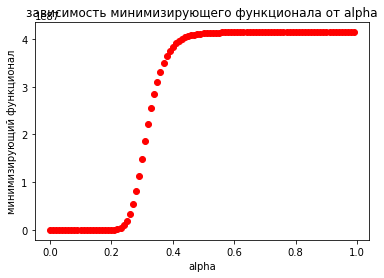

In [15]:
plt.plot(alpha_list, minimize_list, 'ro')
plt.title('зависимость минимизирующего функционала от alpha')
plt.xlabel('alpha')
plt.ylabel('минимизирующий функционал') # см. функцию  minimaze_func
# xlim(0, 0.25)
# ylim(5000, 10000)
plt.show()

##### Замечания на консультации
1. Убрать нормализацию
2. Добавить beta

In [16]:
max_t = df.loc[df['t'].idxmax()]
max_t = max_t['t']
max_t = max_t**2
print(max_t)

def costs_func(i, j, alpha):
    rows = df.loc[df['i'] == i]
    columns = rows.loc[df['j'] == j]
    t = columns['t'] # потому что издержки -- это время
    try:
        t = int(t)
        return np.exp(np.dot(-alpha, t))
    except TypeError: # если не пересекается район i с районом j
        return max_t

def iteration_method(L_i, W_j, alpha):
    A_i = 1
    B_j = 1
    list_A_i = []
    list_B_j = []
    n = L_i.shape[0] # количество районов
    for i in range(1, n+1): # нумерация районов начинается с 1
        for j in range(1, n+1):
            value_i = L_i.loc[L_i['i'] == i]['amt']
            value_j = W_j.loc[W_j['j'] == j]['amt']
            value_i = int(value_i)
            value_j = int(value_j)
            denominator_i = B_j*value_i*costs_func(i, j, alpha)
            denominator_j = A_i*value_j*costs_func(i, j, alpha)
            if denominator_i!=0:
                A_i += denominator_i 
                list_A_i.append(1 / A_i) # вызывает вопросы обращать тут или строкой выше
            else:
                list_A_i.append(0)
            if denominator_j!=0:
                B_j += denominator_j
                list_B_j.append(1 / B_j)
            else:
                list_B_j.append(0)

    return list_A_i, list_B_j

def gravity_func(alpha):
    n = L_i.shape[0] # количество районов
    d_i_j = np.zeros((n+1, n+1))
    list_A_i, list_B_j = iteration_method(L_i, W_j, alpha) # добавлено сюда, чтобы считать с нужным alpha
    for i in range(1, n+1): # нумерация районов начинается с 1
        for j in range(1, n+1):

            value_i = L_i.loc[L_i['i'] == i]['amt']
            value_j = W_j.loc[W_j['j'] == j]['amt']
            value_i = int(value_i)
            value_j = int(value_j)
            cost = costs_func(i, j, alpha)
            if cost!=0:
                d_i_j[i][j] = (list_A_i[i]*list_B_j[j]*value_i*value_j)*cost #умножить потому что -alpha в функции
            else:
                d_i_j[i][j] = 0
    return d_i_j

def minimaze_func(real_d_i_j, alpha, beta):
    d_i_j = gravity_func(alpha) # добавлено сюда, чтобы считать с нужным alpha
    n = L_i.shape[0] # количество районов
    s = 0
    for i in range(n):
        for j in range(n):
            s += (real_d_i_j[i][j] - d_i_j[i][j]**beta)**2
    return s

def get_real_d_i_j(df): # чтобы натыкать нулей в местах, где нет пересечений
    n = L_i.shape[0]
    real_d = np.zeros((n+1, n+1))
    for i in range(1, n+1):
        for j in range(1, n+1):
            value = df.loc[df['i'] == i]
            value = value.loc[value['j'] == j]['amt']
            try:
                value = int(value)
            except TypeError: # если не пересекается район i с районом j
                value = 0
            real_d[i][j] = value
    return real_d

57600.0


In [40]:
real_d_i_j = get_real_d_i_j(df)
list_s = []
alpha_list = []
beta_list = []

# n = 9
# i = 0
# print(np.shape(minimize_list))

# for alpha in np.arange(0, 0.3, 0.1):
#     for beta in np.arange(0, 0.3, 0.1):
#         value = minimaze_func(real_d_i_j, alpha, beta)
#         alpha_list.append(alpha)
#         beta_list.append(beta)
#         minimize_list[i] = value
#         print('alpha: ', alpha, 'min: ', value)
#         i += 0
        
alpha = 0
beta = 0
minimize_list = np.zeros((3, 3))
for i in range(0, 3):
    for j in range(0, 3):
        
        beta += 3*0.1
        alpha += 4*0.1
        value = minimaze_func(real_d_i_j, alpha, beta)
        minimize_list[i][j] = value
        alpha_list.append(alpha)
        beta_list.append(beta)

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in double_scalars
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in double_scalars
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


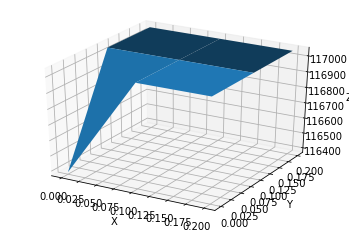

In [42]:
fig = plt.figure()
ax = fig.gca(projection='3d') # get current axis

alpha = np.arange(0, 0.3, 0.1)
beta = np.arange(0, 0.3, 0.1)
alpha, beta = np.meshgrid(alpha, beta)
Z = minimize_list

surf = ax.plot_surface(alpha, beta, Z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()